# Exploratory Data Analysis for WLASL Dataset

Goal:
- Understand what glosses we wanna include for this project
- Understand if bounding box information is useful for this project
- Check the fps of the videos, see if we should preprocess everything into a fixed frame rates


In [1]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [2]:
PROJECT_ROOT = Path(os.getcwd()).parent
RAW_WLASL_DIR = PROJECT_ROOT / "data" / "WLASL"

In [ ]:
# frames_path = PROJECT_ROOT / "data" / "WLASL" / "frames.json" # Useless file
samples_path = RAW_WLASL_DIR / "samples.json"

# Convert from raw dict to dataframe with only useful columns
samples_dict = json.load(open(samples_path, "r"))


def extract_useful_info(sample: dict) -> dict:
    # filepath, metadata.frame_rate, gloss.label, bounding_box.detections[0].bounding_box
    filepath = sample["filepath"]
    frame_rate = sample["metadata"]["frame_rate"]
    gloss_label = sample["gloss"]["label"]
    assert len(sample["bounding_box"]["detections"]) == 1, (
        "Expected only one bounding box detection"
    )
    bbox_x, bbox_y, bbox_w, bbox_h = sample["bounding_box"]["detections"][0][
        "bounding_box"
    ]
    return {
        "filepath": filepath,
        "frame_rate": frame_rate,
        "gloss_label": gloss_label,
        "bbox_x": bbox_x,
        "bbox_y": bbox_y,
        "bbox_w": bbox_w,
        "bbox_h": bbox_h,
    }


df_samples = pd.DataFrame(
    [extract_useful_info(sample) for sample in samples_dict["samples"]]
)
df_samples.head()

,filepath,frame_rate,gloss_label,bbox_x,bbox_y,bbox_w,bbox_h
0,data/data_0/00335.mp4,25.000000,abdomen,0.178125,0.020833,0.590625,0.979167
1,data/data_0/00336.mp4,30.004616,abdomen,0.160938,0.000000,0.721875,1.000000
2,data/data_0/00338.mp4,29.970000,abdomen,0.236111,0.072917,0.506944,0.927083
3,data/data_0/00339.mp4,29.970000,abdomen,0.208333,0.067708,0.524306,0.932292
4,data/data_0/00341.mp4,30.331450,abdomen,0.263889,0.115000,0.529167,0.885000


## 1. Glosses to include

In [4]:
gloss_counts = df_samples["gloss_label"].value_counts()
print(f"Number of unique gloss labels: {len(gloss_counts)}")

Number of unique gloss labels: 2000


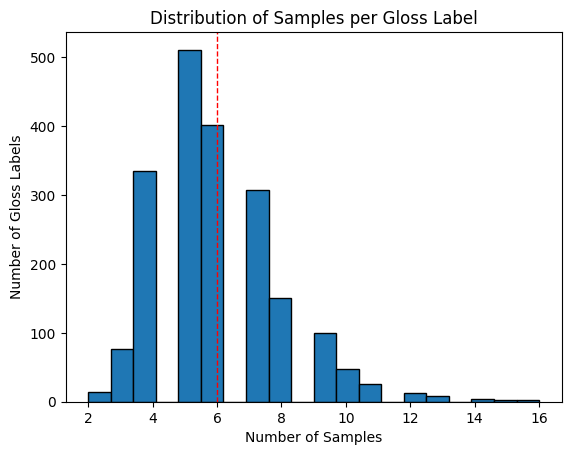

Average number of samples per gloss label: 5.99


In [5]:
# Distribution of samples per gloss label
gloss_counts.plot(kind="hist", bins=20, edgecolor="black")
# Plot an average line (vertical)
plt.axvline(gloss_counts.mean(), color="red", linestyle="dashed", linewidth=1)
plt.title("Distribution of Samples per Gloss Label")
plt.xlabel("Number of Samples")
plt.ylabel("Number of Gloss Labels")
plt.show()

# On average, how many samples are there per gloss label?
average_samples_per_gloss = gloss_counts.mean()
print(f"Average number of samples per gloss label: {average_samples_per_gloss:.2f}")

Aim for around 30 glosses to start with, let's pick every gloss that has at least 13 samples.

In [6]:
# Let's filter gloss labels with at least a certain number of samples
min_samples_threshold = 13
filtered_glosses = gloss_counts[gloss_counts >= min_samples_threshold]
print(
    f"Number of gloss labels with at least {min_samples_threshold} samples: {len(filtered_glosses)}"
)

# Number of samples in the filtered gloss labels
print(f"Total number of samples in filtered gloss labels: {filtered_glosses.sum()}")
print(
    f"Percentage of total samples: {filtered_glosses.sum() / len(df_samples) * 100:.2f}%"
)

Number of gloss labels with at least 13 samples: 17
Total number of samples in filtered gloss labels: 238
Percentage of total samples: 1.99%


In [7]:
# Some sentences we wanna support
sentences = [
    ["please", "help", "me", "find", "bathroom"],
    ["i", "like", "pizza"],
    ["who", "tall", "man"],
    ["thank you", "good", "man"],
    ["son", "accident", "help", "doctor", "now", "hospital"],
    ["no", "wait", "bad"],
    ["thank you"],
    ["i", "you", "me"]
]

# Check number of samples for each gloss in the sentences
for sentence in sentences:
    print(f"Sentence: {' '.join(sentence)}")
    for gloss in sentence:
        count = gloss_counts.get(gloss, 0)
        assert count != 0, f"Gloss '{gloss}' not found in dataset!"
        print(f"  Gloss: {gloss}, Samples: {count}")


Sentence: please help me find bathroom
  Gloss: please, Samples: 7
  Gloss: help, Samples: 14
  Gloss: me, Samples: 4
  Gloss: find, Samples: 8
  Gloss: bathroom, Samples: 7
Sentence: i like pizza
  Gloss: i, Samples: 4
  Gloss: like, Samples: 10
  Gloss: pizza, Samples: 12
Sentence: who tall man
  Gloss: who, Samples: 14
  Gloss: tall, Samples: 13
  Gloss: man, Samples: 12
Sentence: thank you good man
  Gloss: thank you, Samples: 7
  Gloss: good, Samples: 10
  Gloss: man, Samples: 12
Sentence: son accident help doctor now hospital
  Gloss: son, Samples: 10
  Gloss: accident, Samples: 13
  Gloss: help, Samples: 14
  Gloss: doctor, Samples: 10
  Gloss: now, Samples: 9
  Gloss: hospital, Samples: 7
Sentence: no wait bad
  Gloss: no, Samples: 11
  Gloss: wait, Samples: 10
  Gloss: bad, Samples: 10
Sentence: thank you
  Gloss: thank you, Samples: 7
Sentence: i you me
  Gloss: i, Samples: 4
  Gloss: you, Samples: 8
  Gloss: me, Samples: 4


In [8]:
# Number of glosses
sentence_glosses = set([gloss for sentence in sentences for gloss in sentence])
print(f"Total unique glosses in sentences: {len(sentence_glosses)}")

# Total number of samples across all glosses in the sentences
total_samples_in_sentences = sum(
    [gloss_counts.get(gloss, 0) for gloss in sentence_glosses]
)
print(f"Total samples across all glosses in sentences: {total_samples_in_sentences}")

# Percentage of total samples these glosses represent
print(
    f"Percentage of total samples these glosses represent: {total_samples_in_sentences / len(df_samples) * 100:.2f}%"
)

Total unique glosses in sentences: 22
Total samples across all glosses in sentences: 210
Percentage of total samples these glosses represent: 1.75%


In [9]:
# Mix gloss with >= min_samples_threshold samples & those in sentences
selected_glosses = set(filtered_glosses.index).union(sentence_glosses)
# columns: gloss_label, num_samples (filtered to selected_glosses)
df_glosses_sel = (
    pd.DataFrame(
        {
            "gloss_label": list(selected_glosses),
            "num_samples": [gloss_counts.get(gloss, 0) for gloss in selected_glosses],
        }
    )
    .sort_values(by="num_samples", ascending=False)
    .reset_index(drop=True)
)

print(f"Total selected gloss labels: {len(df_glosses_sel)}")
print(f"Total samples in selected gloss labels: {df_glosses_sel['num_samples'].sum()}")
print(
    f"Percentage of total samples: {df_glosses_sel['num_samples'].sum() / len(df_samples) * 100:.2f}%"
)


Total selected gloss labels: 35
Total samples in selected gloss labels: 394
Percentage of total samples: 3.29%


In [10]:
df_glosses_sel

,gloss_label,num_samples
0,before,16
1,cool,16
2,thin,16
3,go,15
4,drink,15
5,help,14
6,computer,14
7,cousin,14
8,who,14
9,bowling,13


In [11]:
# Filter df_samples to only selected glosses
df_samples_sel = df_samples[
    df_samples["gloss_label"].isin(df_glosses_sel["gloss_label"])
].reset_index(drop=True)
print(f"Filtered samples dataframe shape: {df_samples_sel.shape}")
df_samples_sel.head()


Filtered samples dataframe shape: (394, 7)


,filepath,frame_rate,gloss_label,bbox_x,bbox_y,bbox_w,bbox_h
0,data/data_0/00623.mp4,25.000000,accident,0.168750,0.025000,0.681250,0.975000
1,data/data_0/00624.mp4,29.970000,accident,0.131250,0.025000,0.737500,0.975000
2,data/data_0/00625.mp4,23.976118,accident,0.351562,0.046296,0.409375,0.953704
3,data/data_0/00626.mp4,23.976024,accident,0.252604,0.078704,0.584896,0.921296
4,data/data_0/00627.mp4,29.970030,accident,0.344792,0.050000,0.402083,0.950000


In [12]:
# Print the glosses that are selected (copyable list)
print(f"Selected glosses: {len(df_glosses_sel)}")
print(",".join([f"{gloss}" for gloss in df_glosses_sel["gloss_label"]]))

Selected glosses: 35
before,cool,thin,go,drink,help,computer,cousin,who,bowling,trade,bed,accident,tall,thanksgiving,candy,short,pizza,man,no,wait,good,bad,son,like,doctor,now,find,you,thank you,please,hospital,bathroom,me,i


> Verdict: 35 glosses selected based on combined criteria of minimum samples (>= 13) and presence in curated sentences.

## 2. Frame Rates of Videos

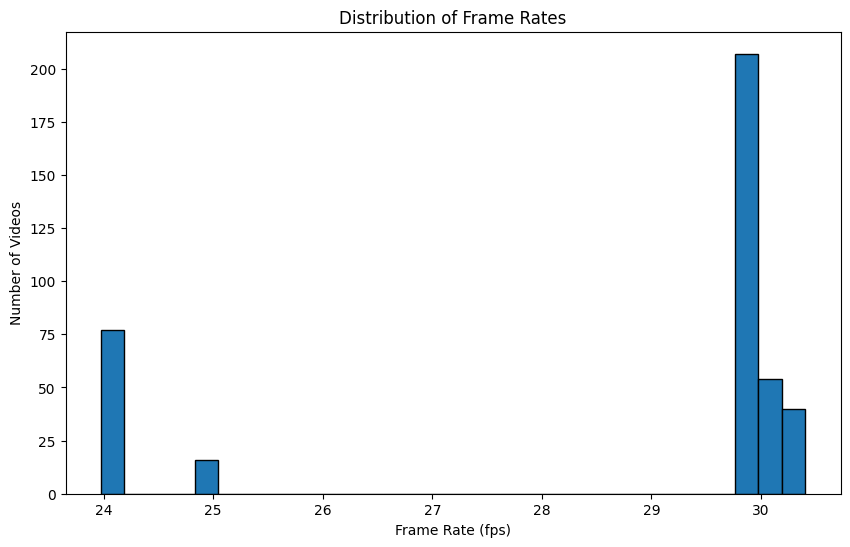

In [13]:
# Plot distribution of frame rates
plt.figure(figsize=(10, 6))
df_samples_sel["frame_rate"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Distribution of Frame Rates")
plt.xlabel("Frame Rate (fps)")
plt.ylabel("Number of Videos")
plt.show()

> Verdict: Let's normalize everything to 24 fps later.

## 3. Bounding Box Information

See if we should crop to bounding box or not.


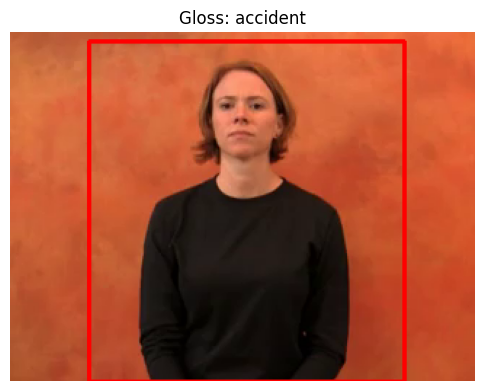

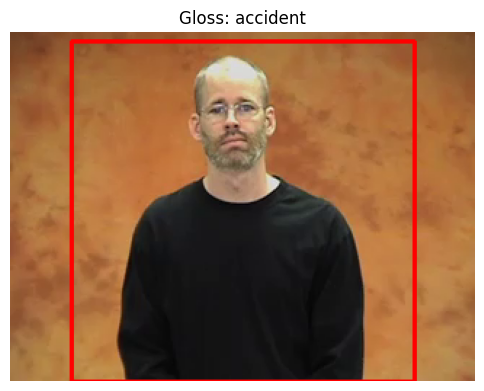

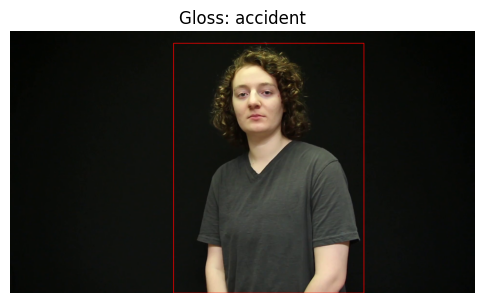

In [14]:
def show_bbox_on_frame(
    filepath,
    bbox_x,
    bbox_y,
    bbox_w,
    bbox_h,
    gloss_label,
    frame_idx=0,
):
    cap = cv2.VideoCapture(filepath)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to read frame")
        return

    H, W, _ = frame.shape

    x1 = int(bbox_x * W)
    y1 = int(bbox_y * H)
    x2 = int((bbox_x + bbox_w) * W)
    y2 = int((bbox_y + bbox_h) * H)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(frame_rgb)
    plt.title(f"Gloss: {gloss_label}")
    plt.axis("off")
    plt.show()


# Show bounding box on a few sample frames
for i in range(3):
    row = df_samples_sel.iloc[i]
    show_bbox_on_frame(
        filepath=RAW_WLASL_DIR / row["filepath"],
        bbox_x=row["bbox_x"],
        bbox_y=row["bbox_y"],
        bbox_w=row["bbox_w"],
        bbox_h=row["bbox_h"],
        gloss_label=row["gloss_label"],
        frame_idx=0,
    )

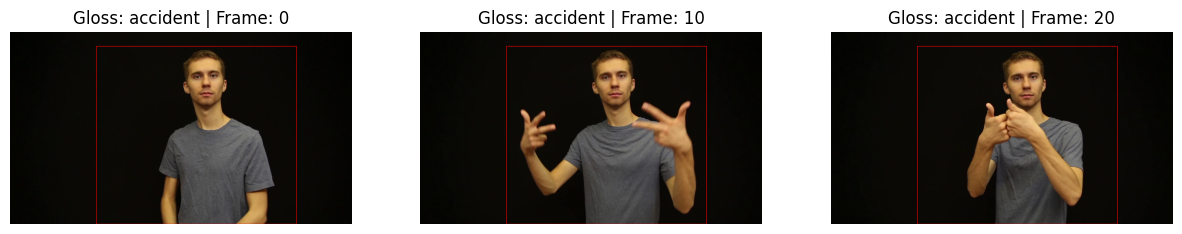

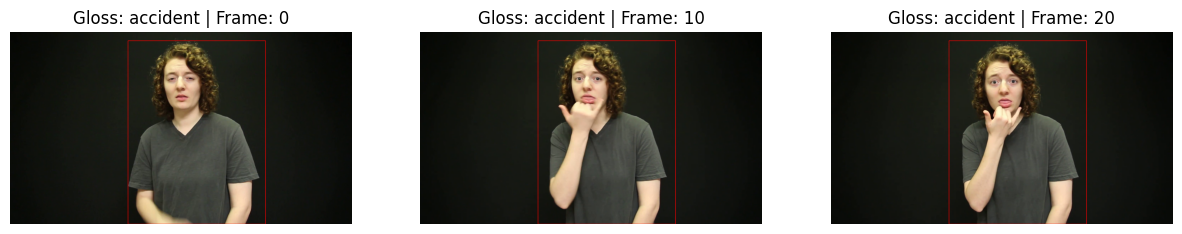

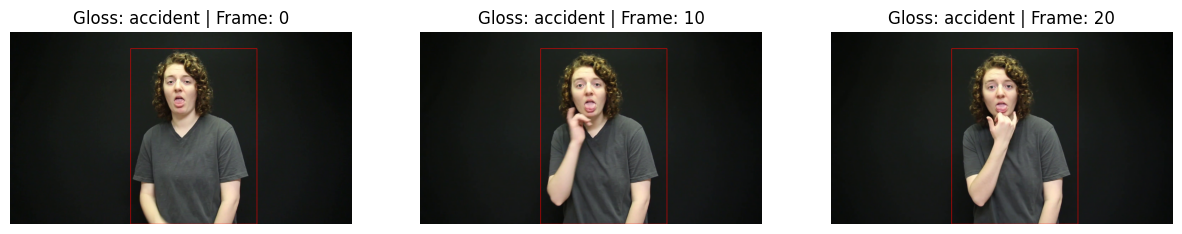

In [15]:
def show_bbox_sequence(
    filepath,
    bbox_x,
    bbox_y,
    bbox_w,
    bbox_h,
    gloss_label,
    frame_indices=(0, 10, 20),
):
    cap = cv2.VideoCapture(filepath)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        H, W, _ = frame.shape
        x1 = int(bbox_x * W)
        y1 = int(bbox_y * H)
        x2 = int((bbox_x + bbox_w) * W)
        y2 = int((bbox_y + bbox_h) * H)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        frames.append(frame)

    cap.release()

    plt.figure(figsize=(15, 5))
    for i, f in enumerate(frames):
        plt.subplot(1, len(frames), i + 1)
        plt.imshow(f)
        plt.axis("off")
        plt.title(f"Gloss: {gloss_label} | Frame: {frame_indices[i]}")
    plt.show()


# Show bounding box sequences for a few samples
for i in range(3, 6):
    row = df_samples_sel.iloc[i]
    show_bbox_sequence(
        filepath=RAW_WLASL_DIR / row["filepath"],
        bbox_x=row["bbox_x"],
        bbox_y=row["bbox_y"],
        bbox_w=row["bbox_w"],
        bbox_h=row["bbox_h"],
        gloss_label=row["gloss_label"],
        frame_indices=(0, 10, 20),
    )

The bbox seems to be quite tight, we should expand it a bit when cropping (10 - 20%). Let's try.

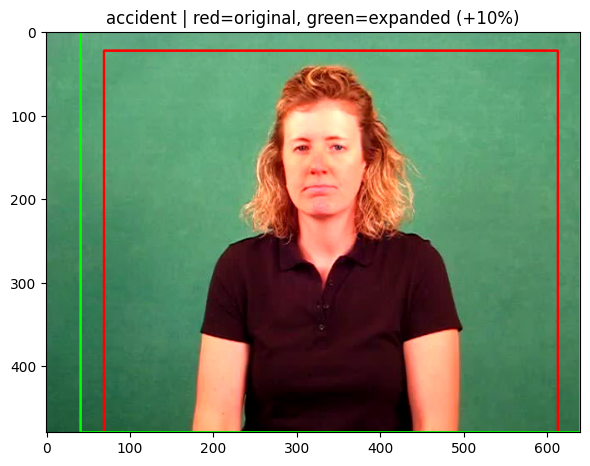

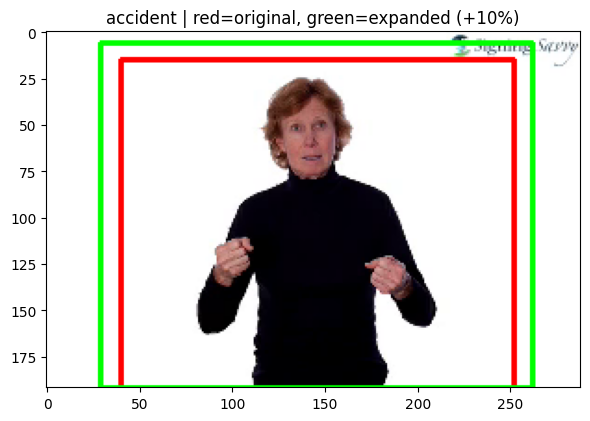

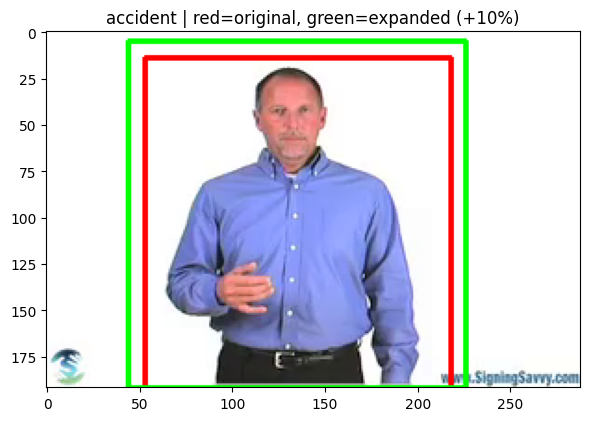

In [16]:
# Let's try expand bbox and see how it looks like
def expand_bbox_norm(bbox_x, bbox_y, bbox_w, bbox_h, expansion_factor=0.2):
    # Expand bbox by a certain factor (normalized coords)
    center_x = bbox_x + bbox_w / 2
    center_y = bbox_y + bbox_h / 2

    new_w = bbox_w * (1 + expansion_factor)
    new_h = bbox_h * (1 + expansion_factor)

    new_x = max(0, center_x - new_w / 2)
    new_y = max(0, center_y - new_h / 2)

    # Ensure bbox does not exceed 1.0 in width/height
    if new_x + new_w > 1.0:
        new_w = 1.0 - new_x
    if new_y + new_h > 1.0:
        new_h = 1.0 - new_y

    return new_x, new_y, new_w, new_h


def show_expanded_bbox_on_frame(
    filepath,
    bbox_x,
    bbox_y,
    bbox_w,
    bbox_h,
    gloss_label,
    frame_idx=0,
    expansion_factor=0.2,
):
    # Show original bbox vs expanded bbox in different colors
    filepath = str(filepath)  # important for cv2

    cap = cv2.VideoCapture(filepath)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {filepath}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idx = min(frame_idx, max(0, total_frames - 1))

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise RuntimeError("Failed to read frame")

    H, W = frame.shape[:2]

    # Original bbox (pixel coords)
    ox1 = int(bbox_x * W)
    oy1 = int(bbox_y * H)
    ox2 = int((bbox_x + bbox_w) * W)
    oy2 = int((bbox_y + bbox_h) * H)

    # Expanded bbox (normalized -> pixel)
    ex, ey, ew, eh = expand_bbox_norm(bbox_x, bbox_y, bbox_w, bbox_h, expansion_factor)
    ex1 = int(ex * W)
    ey1 = int(ey * H)
    ex2 = int((ex + ew) * W)
    ey2 = int((ey + eh) * H)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Draw original bbox (RED)
    cv2.rectangle(frame_rgb, (ox1, oy1), (ox2, oy2), (255, 0, 0), 2)

    # Draw expanded bbox (GREEN)
    cv2.rectangle(frame_rgb, (ex1, ey1), (ex2, ey2), (0, 255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(frame_rgb)
    plt.title(
        f"{gloss_label} | red=original, green=expanded (+{int(expansion_factor * 100)}%)"
    )
    # plt.axis("off")
    plt.tight_layout()
    plt.show()


# Show expanded bounding box on a few sample frames
for i in range(6, 9):
    row = df_samples_sel.iloc[i]
    show_expanded_bbox_on_frame(
        filepath=RAW_WLASL_DIR / row["filepath"],
        bbox_x=row["bbox_x"],
        bbox_y=row["bbox_y"],
        bbox_w=row["bbox_w"],
        bbox_h=row["bbox_h"],
        gloss_label=row["gloss_label"],
        frame_idx=0,
        expansion_factor=0.1,
    )

> Verdict: Use the bbox but expand by 10% on all sides when cropping.